# Animating the Spatial Information from the Wareham River

An experimental notebook to animate and embed the spatial maps of transects taken in the Wareham River. The intent is to get a sense of both temporal and spatial dynamics of the plume. Some interpolation techniques are used here. A discussion about how to use this data in a simulated environment is found at the end.

## Importing Libraries, Dependencies, and Data

In [1]:
#necessary imports
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import animation, rc, cm
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from descartes import PolygonPatch
from shapely.geometry import LineString, Point, Polygon
import shapefile

from IPython.display import HTML, display

import sensor_plotting as sp

/home/vpreston/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/vpreston/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# setting matplotlib display params
rc('animation', html='html5')
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.facecolor'] = '0.75'

# setting pandas display params
pd.set_option('display.max_columns', None)

In [3]:
# creating the data file references

# Instruments, All Transects
ctd_fn = './Cleaned_Data/ctd.csv'
gga_fn = './Cleaned_Data/gga.csv'
op_fn ='./Cleaned_Data/op.csv'
airmar_fn ='./Cleaned_Data/airmar.csv'
dge_fn= './Cleaned_Data/dge.csv'
nitrate_fn = './Cleaned_Data/nitrate.csv'

# All data
all_fn = './Cleaned_Data/interpolated_complete_data.csv'

# Transects
a_fn = './Cleaned_Data/transectA.csv'
b_fn = './Cleaned_Data/transectB.csv'
c_fn = './Cleaned_Data/transectC.csv'
d_fn = './Cleaned_Data/transectD.csv'
e_fn = './Cleaned_Data/transectE.csv'
# f_fn = './Cleaned_Data/transectF.csv'

### Read in Data

In [4]:
# Instruments
ctd = pd.read_table(ctd_fn, delimiter=',', header=0)
gga = pd.read_table(gga_fn, delimiter=',', header=0)
op = pd.read_table(op_fn, delimiter=',', header=0)
airmar = pd.read_table(airmar_fn, delimiter=',', header=0)
dge = pd.read_table(dge_fn, delimiter=',', header=0)
nitrate = pd.read_table(nitrate_fn, delimiter=',', header=0)

In [5]:
# Complete Data
df = pd.read_table(all_fn, delimiter=',', header=[0,1])

/home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Transects
ta = pd.read_table(a_fn, delimiter=',', header=[0,1])
tb = pd.read_table(b_fn, delimiter=',', header=[0,1])
tc = pd.read_table(c_fn, delimiter=',', header=[0,1])
td = pd.read_table(d_fn, delimiter=',', header=[0,1])
te = pd.read_table(e_fn, delimiter=',', header=[0,1])
# tf = pd.read_table(f_fn, delimiter=',', header=[0,1])

/home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Inline and GIF Animations of Raw Data
The intent of animating the data inthe Wareham set is to better capture the idea of temporally and spatially dynamic measurements. Animating the measurements as they were taken on the robot's path is one way to get a sense of the change in the river. 

Using Matplotlib, the measurements observed in each transect are plotted on the shape of the Wareham River. This is done both inline though HTML5 video players, and by creating giphys from static figures of each transect.

Animations for Salinity, Temperature, Methane, Carbon Dioxide, Oxygen, and Nitrate are done. 

In [13]:
class Data_Animator(object):
    """Wrapper for the animation of pandas dataframe information overlayed on a shapefile"""
    def __init__(self, data,transects,inst_target,meas_target,scale_label,title,vmin,vmax):
        self.data = data
        self.transects = transects
        self.inst_target = inst_target
        self.meas_target = meas_target
        self.title = title
        self.vmin = vmin
        self.vmax = vmax
        
        self.map_c = plt.figure()
        self.ax = self.map_c.gca()
        self.ax.axis(xmin=-70.691185, ymin=41.756619, xmax=-70.678, ymax=41.765134)
        self.ax.set_xlabel('Longitude')
        self.ax.set_ylabel('Latitude')
        plt.ticklabel_format(useOffset=False)
        
        # river shapefile
        polys  = shapefile.Reader('./GIS_Data/River.shp')
        poly = polys.iterShapes().next().__geo_interface__
        self.patch = PolygonPatch(poly, fc='green', ec="#6688cc", alpha=0.3, zorder=0)
        self.ax.add_patch(self.patch)
        
        # seed data for initialization
        self.cmap = plt.cm.bwr
        x=data[0]['airmar']['lon_mod'][1:]
        y=data[0]['airmar']['lat_mod'][1:]
        z=data[0][self.inst_target][self.meas_target][1:]
        self.points = self.ax.scatter(x, y, c=z, s=5, alpha=1.0, lw=0, cmap=self.cmap, vmin=self.vmin, vmax=self.vmax)
        self.points.set_clip_path(self.patch)

        # label for timestamp at beginning of transect
        self.timestamp = self.ax.text(0.8, 0.9,'matplotlib',horizontalalignment='center',
                    verticalalignment='center', transform = self.ax.transAxes,
                    animated=True, fontsize=14)

        # colorbar
        cbar = self.map_c.colorbar(self.points)
        cbar.set_label(scale_label)
        
        # call the animation
        self.ani = animation.FuncAnimation(self.map_c, self.update, interval=1000, frames=5)
        
    def update(self,fn):
        self.points.remove()
        x=self.data[fn]['airmar']['lon_mod'][1:]
        y=self.data[fn]['airmar']['lat_mod'][1:]
        z=self.data[fn][self.inst_target][self.meas_target][1:]
        self.points = self.ax.scatter(x, y, c=z, s=5, alpha=1.0, lw=0, cmap=self.cmap, vmin=self.vmin, vmax=self.vmax)
        self.points.set_clip_path(self.patch)
        self.timestamp.set_text(str(self.data[fn]['ctd']['Time'][1]))
        self.map_c.suptitle(self.title + self.transects[fn], fontsize=18)
        return self.points
    
    def get_animation(self):
        return self.ani

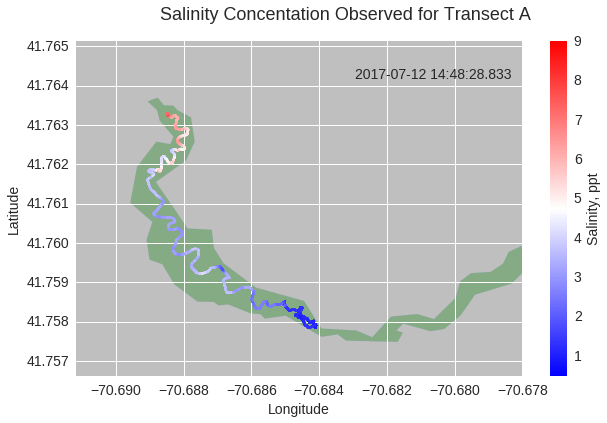

In [14]:
a = Data_Animator([ta,tb,tc,td,te],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'ctd','Salinity','Salinity, ppt',
                  'Salinity Concentation Observed for ', 0.5, 9.0)
anim = a.get_animation()
anim.save('salinity.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

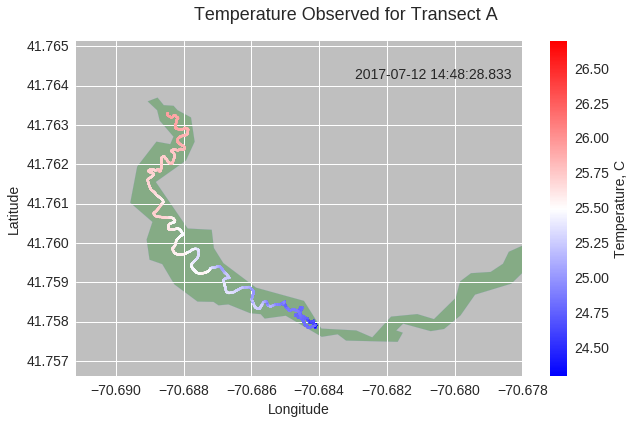

In [52]:
a = Data_Animator([ta,tb,tc,td,te],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'ctd','Temperature','Temperature, C',
                  'Temperature Observed for ', 24.3, 26.7)
anim = a.get_animation()
anim.save('temperature.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

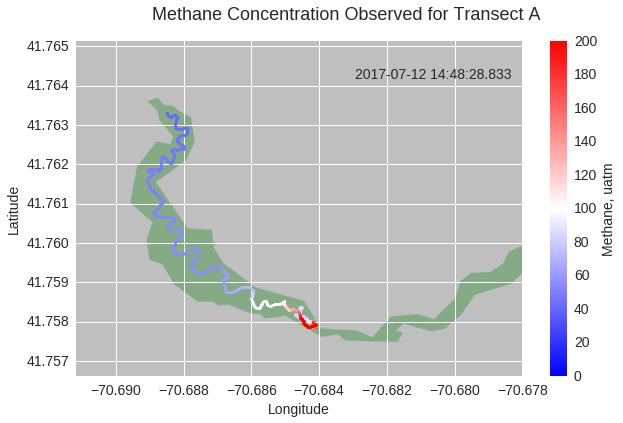

In [42]:
a = Data_Animator([ta,tb,tc,td,te],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'gga','CH4_ppm_adjusted','Methane, uatm',
                  'Methane Concentration Observed for ', 0, 200)
anim = a.get_animation()
anim.save('methane.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

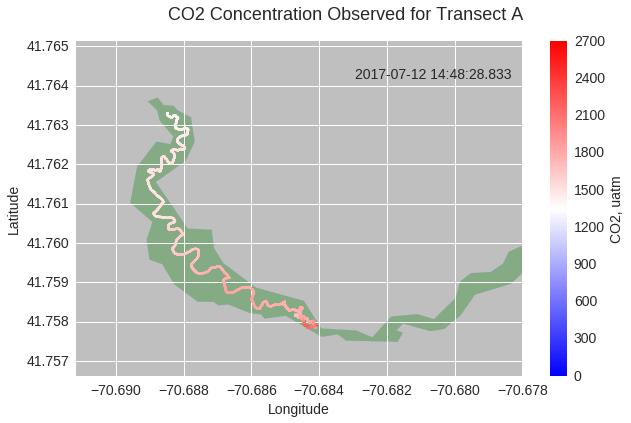

In [43]:
a = Data_Animator([ta,tb,tc,td,te],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'gga','CO2_ppm_adjusted','CO2, uatm',
                  'CO2 Concentration Observed for ', 0, 2700)
anim = a.get_animation()
anim.save('co2.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

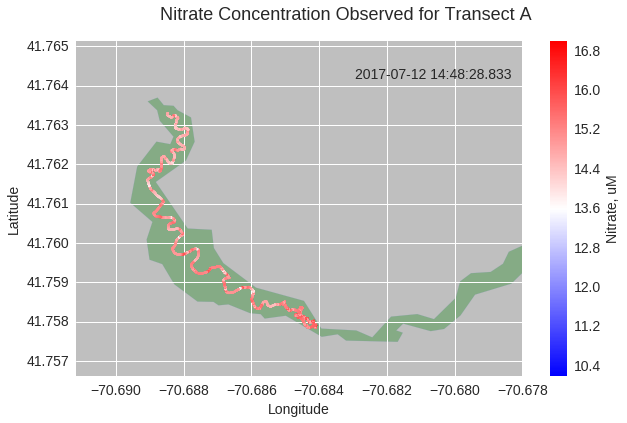

In [15]:
a = Data_Animator([ta,tb,tc,td,te],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'nitrate','0.00','Nitrate, uM',
                  'Nitrate Concentration Observed for ', 10.2, 17)
anim = a.get_animation()
anim.save('nitrate.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

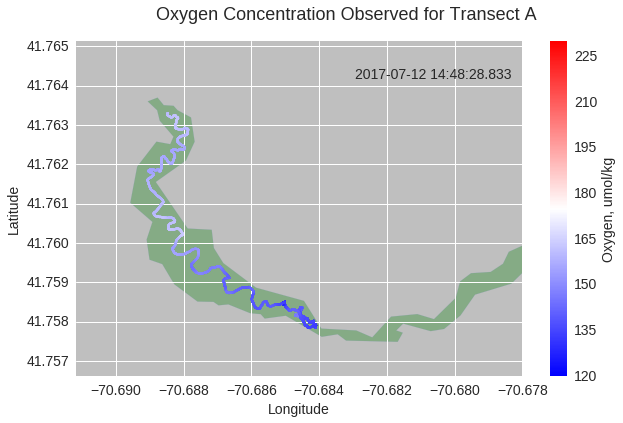

In [16]:
a = Data_Animator([ta,tb,tc,td,te],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'op','O2Concentration','Oxygen, umol/kg',
                  'Oxygen Concentration Observed for ', 120, 230)
anim = a.get_animation()
anim.save('oxy.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

An alternative way of making these gifs would be to actually just generate still images of each transect, and then use a commandline tool to write a gif. See [this blogpost](https://waterprogramming.wordpress.com/2016/03/01/making-movies-of-time-evolving-global-maps-with-python/) which describes the process.

```
convert -delay 45 -loop 0 *.png clever_gif_name.gif
```
Code to generate still is provided below for completeness.


In [ ]:
# Sample function for creating still images
def create_imgs(x,y,data, label, title, ll):
    map_c = plt.figure()
    ax = map_c.gca()
    
    polys  = shapefile.Reader('./GIS_Data/River.shp')
    poly = polys.iterShapes().next().__geo_interface__
    patch = PolygonPatch(poly, fc='green', ec="#6688cc", alpha=0.3, zorder=0)
    ax.add_patch(patch)
    ax.axis(xmin=-70.691185, ymin=41.756619, xmax=-70.678, ymax=41.765134)

    cmap = plt.cm.bwr
    points = ax.scatter(x, y, c=data, s=5, alpha=1.0, lw=0, cmap=cmap, vmin=0.5, vmax=9.0)
    cbar = map_c.colorbar(points)
    cbar.set_label(label)
    points.set_clip_path(patch)

    map_c.suptitle('Raw Plotted Data for ' + title, fontsize=18)
    map_c.savefig(ll)
    return

In [ ]:
# Sample function for creating salinity images in particular
def create_salinity_plots(df_list, label_list):
    for df, ll in zip(df_list, label_list):
        x=df['airmar']['lon_mod'][1:]
        y=df['airmar']['lat_mod'][1:]
        bins=50

        salinity=df['ctd']['Salinity'][1:]
        create_imgs(x,y,salinity,'Salinity Level', 'Salinity Across Transects', ll)

create_salinity_plots([ta, tb, tc, td, te], ['a','b','c','d','e'])

The resulting gif:

<img src="salinity.gif">

## Making More Compelling Animations: Interpolating and Extrapolating

The gif of the sampled points isn't exactly as compelling as it could be. Using some interpolation/extrpolation methods could allow us to "fill in" the rest of the river, and those images can be subsequently animated.

In [20]:
# let's start by getting relevant libraries for this process
from scipy.interpolate import griddata, Rbf
import scipy.optimize
from scipy.integrate import quad
from matplotlib.path import Path
from matplotlib.patches import PathPatch

### Extrapolating through Euclidean Distance
First, I will use a typical Euclidean Distance linear interpolator using the RBF (radial basis function) implementation in scipy. 

While euclidean distance is often a fairly good estimator of how closely some points in space are related, for the river shape this is a bit trickier -- the curve means that one point at the end of the river may be quite close to a point on the other side of the river as the crow flies, but doesn't have nearly as large an affect on that point as that metric may imply. 

To use the RBF, I will need to extrpolate/interpolate on a regular grid. I will then mask the function using the river shapefile. 

The next section will discuss designing a kernel that may better encapsulate the knowledge that the spatial data is related by the curve of the river.

In [59]:
# alternative euclidean distance kernels to the default, provided for completeness
def euclidean_norm(x1, x2):
    """Re-implementation of the default euclidean distance kernel"""e
    return np.sqrt( ((x1 - x2)**2).sum(axis=0) )

def get_distance(x1, x2):
    """Euclidean distance kernal which considers the curvature of the earth"""
    global river    
    R = 6373.0
    
    dlon = x2[0] - x1[0]
    dlat = x2[1] - x1[1]

    a = np.sin(dlat / 2)**2 + np.cos(x2[1]) * np.cos(x1[1]) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    dist = R*c*1000.0
    return dist

In [21]:
class Interp_Animator(object):
    """Wrapper for the animation of pandas dataframe information interpolated on a shapefile"""
    def __init__(self, data,transects,inst_target,meas_target,scale_label,title,vmin,vmax):
        self.data = data
        self.transects = transects
        self.inst_target = inst_target
        self.meas_target = meas_target
        self.title = title
        self.vmin = vmin
        self.vmax = vmax
        
        self.map_c = plt.figure()
        self.ax = self.map_c.gca()
        self.ax.axis(xmin=-70.691185, ymin=41.756619, xmax=-70.678, ymax=41.765134)
        self.ax.set_xlabel('Longitude')
        self.ax.set_ylabel('Latitude')
        plt.ticklabel_format(useOffset=False)
        
        # river shapefile
        polys  = shapefile.Reader('./GIS_Data/River.shp')
        poly = polys.iterShapes().next().__geo_interface__
        self.patch = PolygonPatch(poly, fc='green', ec="#6688cc", alpha=0.3, zorder=0)
        self.ax.add_patch(self.patch)
        
        # seed data for initialization
        self.cmap = plt.cm.bwr
        x=data[0]['airmar']['lon_mod'][1::20]
        y=data[0]['airmar']['lat_mod'][1::20]
        z=data[0][self.inst_target][self.meas_target][1::20]
        
        xi = np.linspace(-70.691185, -70.678, 70)
        yi = np.linspace(41.756619, 41.765134, 70)
        self.xi, self.yi = np.meshgrid(xi,yi)
        
        zfunction = Rbf(x, y, z, epsilon=2, function='linear')
        zi = zfunction(self.xi, self.yi)

        self.cs = self.ax.contourf(self.xi,self.yi,zi, 
                                   cmap=plt.cm.bwr, 
                                   levels=np.linspace(self.vmin, self.vmax, 9), 
                                   extend='both')
        for contour in self.cs.collections:
            contour.set_clip_path(self.patch)        

        # label for timestamp at beginning of transect
        self.timestamp = self.ax.text(0.8, 0.9,'matplotlib',horizontalalignment='center',
                    verticalalignment='center', transform = self.ax.transAxes,
                    animated=True, fontsize=14)

        # colorbar
        cbar = self.map_c.colorbar(self.cs)
        cbar.set_label(scale_label)
        
        # call the animation
        self.ani = animation.FuncAnimation(self.map_c, self.update, interval=1000, frames=5)
        
    def update(self,fn):
        for contour in self.cs.collections:
            contour.remove()
        x=self.data[fn]['airmar']['lon_mod'][1::20]
        y=self.data[fn]['airmar']['lat_mod'][1::20]
        z=self.data[fn][self.inst_target][self.meas_target][1::20]
        zfunction = Rbf(x, y, z, epsilon=2, function='linear')
        zi = zfunction(self.xi, self.yi)
        self.cs = self.ax.contourf(self.xi,self.yi,zi,
                                   cmap=plt.cm.bwr,
                                   levels=np.linspace(self.vmin,self.vmax,9),
                                   extend='both')
        for contour in self.cs.collections:
            contour.set_clip_path(self.patch)
        self.timestamp.set_text(str(self.data[fn]['ctd']['Time'][self.data[fn].first_valid_index()]))
        self.map_c.suptitle(self.title + self.transects[fn], fontsize=18)
        return self.cs
    
    def get_animation(self):
        return self.ani

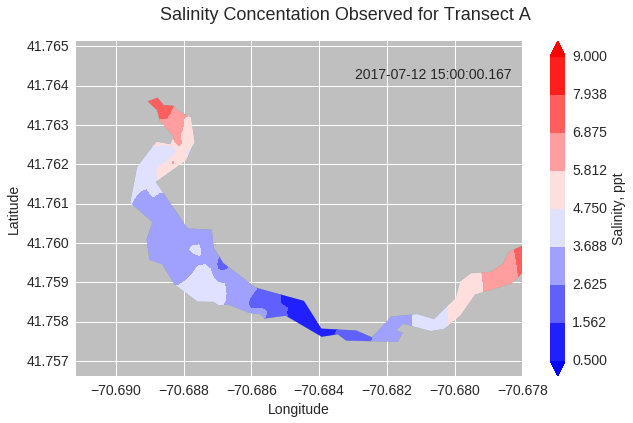

In [35]:
# Create clean datasets for the interpolation -- no null values, and no values with the same x-coordinate (or
# a singular matrix error will be thrown)
tad = ta[ta['airmar']['lon_mod'].notnull() & ta['airmar']['lat_mod'].notnull() & ta['ctd']['Salinity'].notnull()]
tad = tad[~tad['airmar']['lon_mod'].duplicated()]
tbd = tb[tb['airmar']['lon_mod'].notnull() & tb['airmar']['lat_mod'].notnull() & tb['ctd']['Salinity'].notnull()]
tbd = tbd[~tbd['airmar']['lon_mod'].duplicated()]
tcd = tc[tc['airmar']['lon_mod'].notnull() & tc['airmar']['lat_mod'].notnull() & tc['ctd']['Salinity'].notnull()]
tcd = tcd[~tcd['airmar']['lon_mod'].duplicated()]
tdd = td[td['airmar']['lon_mod'].notnull() & td['airmar']['lat_mod'].notnull() & td['ctd']['Salinity'].notnull()]
tdd = tdd[~tdd['airmar']['lon_mod'].duplicated()]
ted = te[te['airmar']['lon_mod'].notnull() & te['airmar']['lat_mod'].notnull() & te['ctd']['Salinity'].notnull()]
ted = ted[~ted['airmar']['lon_mod'].duplicated()]

# Perform the interpolation
a = Interp_Animator([tad, tbd, tcd, tdd, ted],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'ctd','Salinity','Salinity, ppt',
                  'Salinity Concentation Observed for ', 0.5, 9.0)
anim = a.get_animation()
anim.save('salinity_linear_interpolation.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

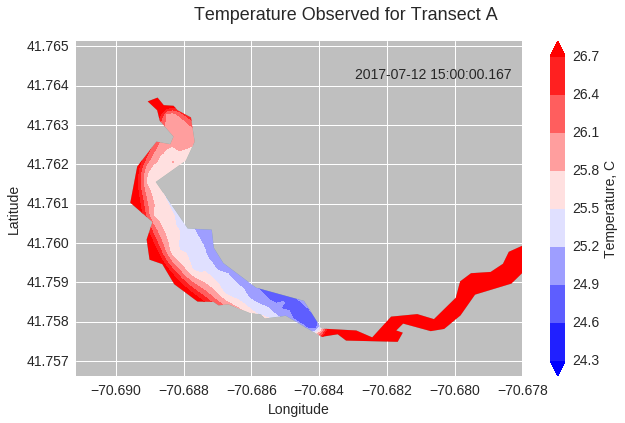

In [105]:
# Create clean datasets for the interpolation -- no null values, and no values with the same x-coordinate (or
# a singular matrix error will be thrown)
tad = ta[ta['airmar']['lon_mod'].notnull() & ta['airmar']['lat_mod'].notnull() & ta['ctd']['Temperature'].notnull()]
tad = tad[~tad['airmar']['lon_mod'].duplicated()]
tbd = tb[tb['airmar']['lon_mod'].notnull() & tb['airmar']['lat_mod'].notnull() & tb['ctd']['Temperature'].notnull()]
tbd = tbd[~tbd['airmar']['lon_mod'].duplicated()]
tcd = tc[tc['airmar']['lon_mod'].notnull() & tc['airmar']['lat_mod'].notnull() & tc['ctd']['Temperature'].notnull()]
tcd = tcd[~tcd['airmar']['lon_mod'].duplicated()]
tdd = td[td['airmar']['lon_mod'].notnull() & td['airmar']['lat_mod'].notnull() & td['ctd']['Temperature'].notnull()]
tdd = tdd[~tdd['airmar']['lon_mod'].duplicated()]
ted = te[te['airmar']['lon_mod'].notnull() & te['airmar']['lat_mod'].notnull() & te['ctd']['Temperature'].notnull()]
ted = ted[~ted['airmar']['lon_mod'].duplicated()]

# Perform the interpolation
a = Interp_Animator([tad, tbd, tcd, tdd, ted],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'ctd','Temperature','Temperature, C',
                  'Temperature Observed for ', 24.3, 26.7)
anim = a.get_animation()
anim.save('temperature_linear_interpolation.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

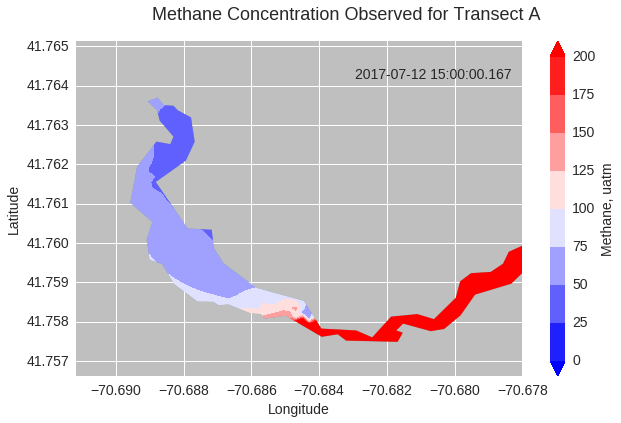

In [41]:
# Create clean datasets for the interpolation -- no null values, and no values with the same x-coordinate (or
# a singular matrix error will be thrown)
tad = ta[ta['airmar']['lon_mod'].notnull() & ta['airmar']['lat_mod'].notnull() & ta['gga']['CH4_ppm_adjusted'].notnull()]
tad = tad[~tad['airmar']['lon_mod'].duplicated()]
tbd = tb[tb['airmar']['lon_mod'].notnull() & tb['airmar']['lat_mod'].notnull() & tb['gga']['CH4_ppm_adjusted'].notnull()]
tbd = tbd[~tbd['airmar']['lon_mod'].duplicated()]
tcd = tc[tc['airmar']['lon_mod'].notnull() & tc['airmar']['lat_mod'].notnull() & tc['gga']['CH4_ppm_adjusted'].notnull()]
tcd = tcd[~tcd['airmar']['lon_mod'].duplicated()]
tdd = td[td['airmar']['lon_mod'].notnull() & td['airmar']['lat_mod'].notnull() & td['gga']['CH4_ppm_adjusted'].notnull()]
tdd = tdd[~tdd['airmar']['lon_mod'].duplicated()]
ted = te[te['airmar']['lon_mod'].notnull() & te['airmar']['lat_mod'].notnull() & te['gga']['CH4_ppm_adjusted'].notnull()]
ted = ted[~ted['airmar']['lon_mod'].duplicated()]

# Perform the interpolation
a = Interp_Animator([tad, tbd, tcd, tdd, ted],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'gga','CH4_ppm_adjusted','Methane, uatm',
                  'Methane Concentration Observed for ', 0, 200)
anim = a.get_animation()
anim.save('methane_linear_interpolation.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

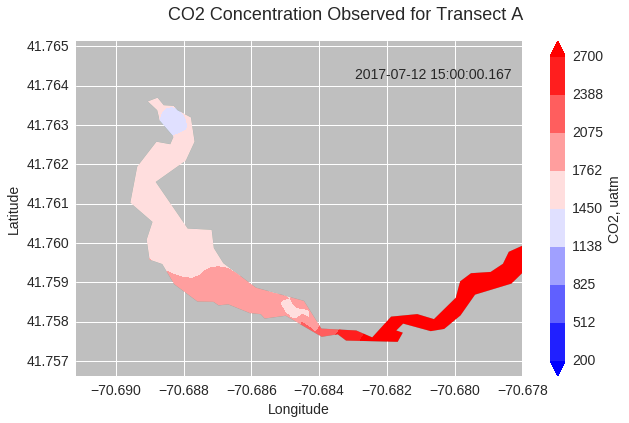

In [40]:
# Create clean datasets for the interpolation -- no null values, and no values with the same x-coordinate (or
# a singular matrix error will be thrown)
tad = ta[ta['airmar']['lon_mod'].notnull() & ta['airmar']['lat_mod'].notnull() & ta['gga']['CO2_ppm_adjusted'].notnull()]
tad = tad[~tad['airmar']['lon_mod'].duplicated()]
tbd = tb[tb['airmar']['lon_mod'].notnull() & tb['airmar']['lat_mod'].notnull() & tb['gga']['CO2_ppm_adjusted'].notnull()]
tbd = tbd[~tbd['airmar']['lon_mod'].duplicated()]
tcd = tc[tc['airmar']['lon_mod'].notnull() & tc['airmar']['lat_mod'].notnull() & tc['gga']['CO2_ppm_adjusted'].notnull()]
tcd = tcd[~tcd['airmar']['lon_mod'].duplicated()]
tdd = td[td['airmar']['lon_mod'].notnull() & td['airmar']['lat_mod'].notnull() & td['gga']['CO2_ppm_adjusted'].notnull()]
tdd = tdd[~tdd['airmar']['lon_mod'].duplicated()]
ted = te[te['airmar']['lon_mod'].notnull() & te['airmar']['lat_mod'].notnull() & te['gga']['CO2_ppm_adjusted'].notnull()]
ted = ted[~ted['airmar']['lon_mod'].duplicated()]

# Perform the interpolation
a = Interp_Animator([tad, tbd, tcd, tdd, ted],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'gga','CO2_ppm_adjusted','CO2, uatm',
                  'CO2 Concentration Observed for ', 200, 2700)
anim = a.get_animation()
anim.save('co2_linear_interpolation.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

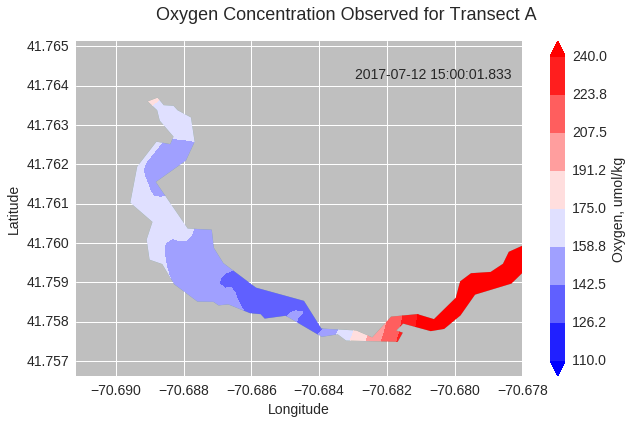

In [22]:
# Create clean datasets for the interpolation -- no null values, and no values with the same x-coordinate (or
# a singular matrix error will be thrown)
tad = ta[ta['airmar']['lon_mod'].notnull() & ta['airmar']['lat_mod'].notnull() & ta['op']['O2Concentration'].notnull()]
tad = tad[~tad['airmar']['lon_mod'].duplicated()]
tbd = tb[tb['airmar']['lon_mod'].notnull() & tb['airmar']['lat_mod'].notnull() & tb['op']['O2Concentration'].notnull()]
tbd = tbd[~tbd['airmar']['lon_mod'].duplicated()]
tcd = tc[tc['airmar']['lon_mod'].notnull() & tc['airmar']['lat_mod'].notnull() & tc['op']['O2Concentration'].notnull()]
tcd = tcd[~tcd['airmar']['lon_mod'].duplicated()]
tdd = td[td['airmar']['lon_mod'].notnull() & td['airmar']['lat_mod'].notnull() & td['op']['O2Concentration'].notnull()]
tdd = tdd[~tdd['airmar']['lon_mod'].duplicated()]
ted = te[te['airmar']['lon_mod'].notnull() & te['airmar']['lat_mod'].notnull() & te['op']['O2Concentration'].notnull()]
ted = ted[~ted['airmar']['lon_mod'].duplicated()]

# Perform the interpolation
a = Interp_Animator([tad, tbd, tcd, tdd, ted],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'op','O2Concentration','Oxygen, umol/kg',
                  'Oxygen Concentration Observed for ', 110, 240)
anim = a.get_animation()
anim.save('oxygen_linear_interpolation.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

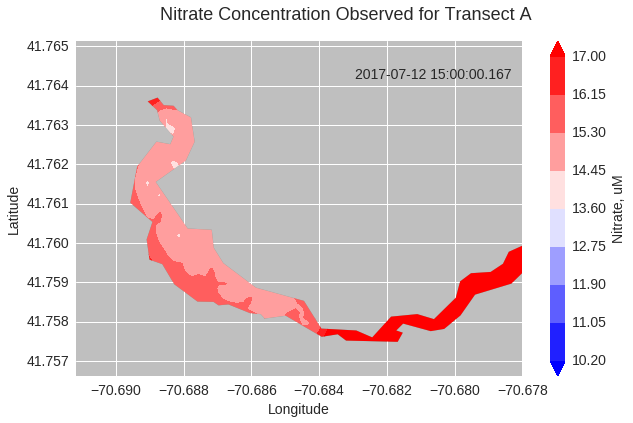

In [23]:
# Create clean datasets for the interpolation -- no null values, and no values with the same x-coordinate (or
# a singular matrix error will be thrown)
tad = ta[ta['airmar']['lon_mod'].notnull() & ta['airmar']['lat_mod'].notnull() & ta['nitrate']['0.00'].notnull()]
tad = tad[~tad['airmar']['lon_mod'].duplicated()]
tbd = tb[tb['airmar']['lon_mod'].notnull() & tb['airmar']['lat_mod'].notnull() & tb['nitrate']['0.00'].notnull()]
tbd = tbd[~tbd['airmar']['lon_mod'].duplicated()]
tcd = tc[tc['airmar']['lon_mod'].notnull() & tc['airmar']['lat_mod'].notnull() & tc['nitrate']['0.00'].notnull()]
tcd = tcd[~tcd['airmar']['lon_mod'].duplicated()]
tdd = td[td['airmar']['lon_mod'].notnull() & td['airmar']['lat_mod'].notnull() & td['nitrate']['0.00'].notnull()]
tdd = tdd[~tdd['airmar']['lon_mod'].duplicated()]
ted = te[te['airmar']['lon_mod'].notnull() & te['airmar']['lat_mod'].notnull() & te['nitrate']['0.00'].notnull()]
ted = ted[~ted['airmar']['lon_mod'].duplicated()]

# Perform the interpolation
a = Interp_Animator([tad, tbd, tcd, tdd, ted],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'nitrate','0.00','Nitrate, uM',
                  'Nitrate Concentration Observed for ', 10.2, 17)
anim = a.get_animation()
anim.save('nitrate_linear_interpolation.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

### Extrapolating With a Different Kernel

As stated before, the euclidean distance metric isn't necessarily the most compelling for our use case. In an attempt to explore more possibilities, different kernels which are related to the geometry of the river curve were designed and implemented. The RBF implementation allows for a kernel, written as a function of an x,y array, to be used to override the default euclidean distance kernel. 

Please see inline comments for more information about the kernels that were designed.

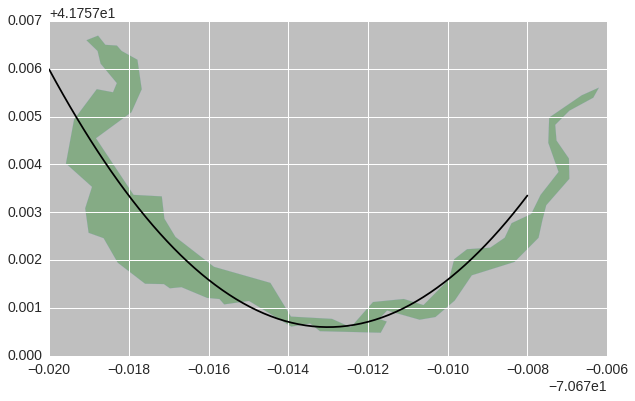

In [24]:
# Determine the rough "function" of the river to be used in the kernel density estimate
polys  = shapefile.Reader('./GIS_Data/River.shp')
poly = polys.iterShapes().next().__geo_interface__        
patch = PolygonPatch(poly, fc='green', ec="#6688cc", alpha=0.3, zorder=0)
shapes = polys.shapes()
river = Polygon(shapes[0].points)

# for now, fitting a polynomial, though generally a sine-generated curve is a more robust option
xi = np.linspace(-70.69, -70.678, 70)
yi = 110*(xi+70.683)**2+41.7576

fig = plt.figure()
ax = fig.add_subplot(111)
ax.add_patch(patch)
plt.plot(xi,yi,'k-')

In [25]:
# helper functions for the kernel estimate
def integrand(x):
    """integrate over the curve to return the distance along the curve"""
    return np.sqrt(1+(220*x + (2*70.683))**2)

def distance(x, y):
    """just the euclidean distance function"""
    arc = np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
    return float(arc)

In [26]:
# the kernel function
def river_dist(x1,x2):
    """kernel which uses a proxy for distance along the river using
    the formula distance_alon_curve + euclidean_distance - 2*distance_from_curve. In theory
    this kernel penalizes elements that are far apart on the curve and rewards elements which
    are relatively close to the estimated curve, or elements which are not far from the curve."""
    #instantiate the kernel
    kernel = np.empty(shape=(0,len(x2[0][0])))
    
    # we want to find the kernel measurement between each point in x1 and each point in x2
    # since we do not have a simple matrix operation, we will need to iterate through each 
    # pair to create the kernel matrix
    for l,a in zip(x1[0],x1[1]):
        axi = [] # container for a row in the matrix
        river_func_x1 = lambda x: (x - l)**2 + (110*(x+70.683)**2+41.7576 - a)**2
        opt_x = scipy.optimize.fmin(func=river_func_x1, x0=[-70.68402], disp=0)
        point = [opt_x[0], 110*(opt_x[0]+70.683)**2+41.7576]
        additx = distance((l,a),point)
        for k,s in zip(x2[0][0], x2[1][0]):
            river_func_x2 = lambda x: (x - k)**2 + (110*(x+70.683)**2+41.7576 - s)**2
            opt_x = scipy.optimize.fmin(func=river_func_x2, x0=[-70.68402], disp=0)
            other = [opt_x[0], 110*(opt_x[0]+70.683)**2+41.7576]
            addit = distance((k,s),other)
#             if other[0] < point[0]:
#                 dist = quad(integrand, point[0], other[0])
#             else:
#                 dist = quad(integrand, other[0], point[0])
            dist =  distance(other,point) + distance((l,a),(k,s)) - 2.0*(addit + additx)
            axi.append(float(dist))
        kernel = np.append(kernel, [axi], axis=0)
    return kernel

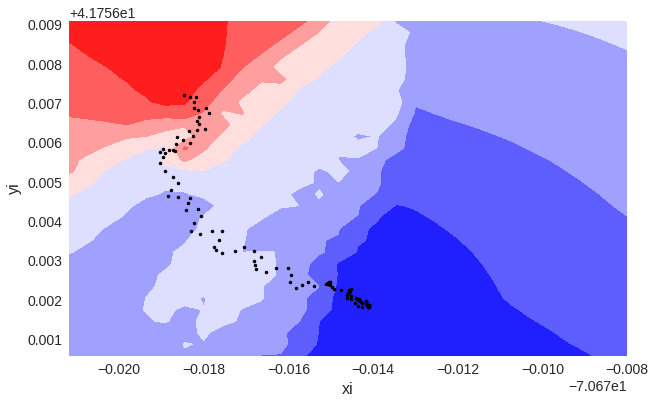

In [27]:
tad = ta[ta['airmar']['lon_mod'].notnull() & ta['airmar']['lat_mod'].notnull() & ta['ctd']['Salinity'].notnull()]

x=tad['airmar']['lon_mod'][1::100]
y=tad['airmar']['lat_mod'][1::100]
salinity=tad['ctd']['Salinity'][1::100]

xi = np.linspace(-70.691185, -70.678, 30)
yi = np.linspace(41.756619, 41.765134, 30)

xi, yi = np.meshgrid(xi,yi)
            
zfunction = Rbf(x, y, salinity, epsilon=0.05, function='linear', norm=river_dist)
zi = zfunction(xi,yi)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis(xmin=-70.691185, ymin=41.756619, xmax=-70.678, ymax=41.765134)
cs = plt.contourf(xi,yi,zi, cmap=plt.cm.bwr)
    
plt.plot(x,y,'k.')
plt.xlabel('xi',fontsize=16)
plt.ylabel('yi',fontsize=16)
plt.show()


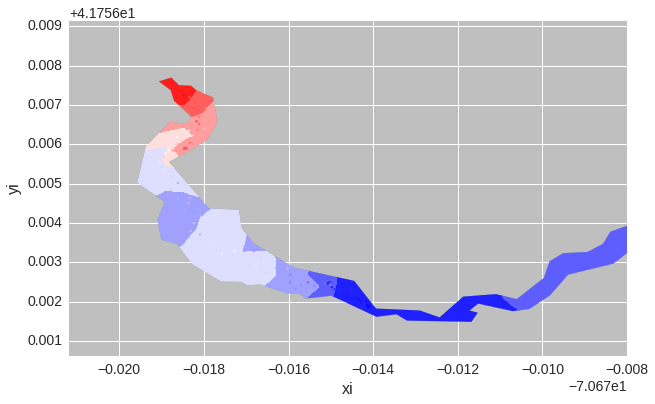

In [28]:
polys  = shapefile.Reader('./GIS_Data/River.shp')
poly = polys.iterShapes().next().__geo_interface__        
patch = PolygonPatch(poly, fc='green', ec="#6688cc", alpha=0.3, zorder=0)
shapes = polys.shapes()
river = Polygon(shapes[0].points)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.add_patch(patch)
ax.axis(xmin=-70.691185, ymin=41.756619, xmax=-70.678, ymax=41.765134)
cs = plt.contourf(xi,yi,zi, cmap=plt.cm.bwr)

points = ax.scatter(x, y, c=salinity, s=5, alpha=1.0, lw=0, cmap=plt.cm.bwr)
# cbar = map_c.colorbar(points)

for contour in cs.collections:
    contour.set_clip_path(patch)
    
# plt.plot(x,y,'k.')
plt.xlabel('xi',fontsize=16)
plt.ylabel('yi',fontsize=16)
plt.show()


In [38]:
class Interp2_Animator(object):
    """Wrapper for the animation of pandas dataframe information interpolated on a shapefile"""
    def __init__(self, data,transects,inst_target,meas_target,scale_label,title,vmin,vmax):
        self.data = data
        self.transects = transects
        self.inst_target = inst_target
        self.meas_target = meas_target
        self.title = title
        self.vmin = vmin
        self.vmax = vmax
        
        self.map_c = plt.figure()
        self.ax = self.map_c.gca()
        self.ax.axis(xmin=-70.691185, ymin=41.756619, xmax=-70.678, ymax=41.765134)
        self.ax.set_xlabel('Longitude')
        self.ax.set_ylabel('Latitude')
        plt.ticklabel_format(useOffset=False)
        
        # river shapefile
        polys  = shapefile.Reader('./GIS_Data/River.shp')
        poly = polys.iterShapes().next().__geo_interface__
        self.patch = PolygonPatch(poly, fc='green', ec="#6688cc", alpha=0.3, zorder=0)
        self.ax.add_patch(self.patch)
        
        # seed data for initialization
        self.cmap = plt.cm.bwr
        x=data[0]['airmar']['lon_mod'][1::20]
        y=data[0]['airmar']['lat_mod'][1::20]
        z=data[0][self.inst_target][self.meas_target][1::20]
        
        xi = np.linspace(-70.691185, -70.678, 30)
        yi = np.linspace(41.756619, 41.765134, 30)
        self.xi, self.yi = np.meshgrid(xi,yi)
        
        zfunction = Rbf(x, y, z, epsilon=2, function='linear', norm=self.river_dist)
        zi = zfunction(self.xi, self.yi)

        self.cs = self.ax.contourf(self.xi,self.yi,zi, 
                                   cmap=plt.cm.bwr, 
                                   levels=np.linspace(self.vmin, self.vmax, 9), 
                                   extend='both')
        for contour in self.cs.collections:
            contour.set_clip_path(self.patch)        

        # label for timestamp at beginning of transect
        self.timestamp = self.ax.text(0.8, 0.9,'matplotlib',horizontalalignment='center',
                    verticalalignment='center', transform = self.ax.transAxes,
                    animated=True, fontsize=14)

        # colorbar
        cbar = self.map_c.colorbar(self.cs)
        cbar.set_label(scale_label)
        
        # call the animation
        self.ani = animation.FuncAnimation(self.map_c, self.update, interval=1000, frames=5)
        
    def river_dist(self,x1,x2):
        """kernel which uses a proxy for distance along the river using
        the formula distance_alon_curve + euclidean_distance - 2*distance_from_curve. In theory
        this kernel penalizes elements that are far apart on the curve and rewards elements which
        are relatively close to the estimated curve, or elements which are not far from the curve."""
        #instantiate the kernel
        kernel = np.empty(shape=(0,len(x2[0][0])))

        # we want to find the kernel measurement between each point in x1 and each point in x2
        # since we do not have a simple matrix operation, we will need to iterate through each 
        # pair to create the kernel matrix
        for l,a in zip(x1[0],x1[1]):
            axi = [] # container for a row in the matrix
            river_func_x1 = lambda x: (x - l)**2 + (110*(x+70.683)**2+41.7576 - a)**2
            opt_x = scipy.optimize.fmin(func=river_func_x1, x0=[-70.68402], disp=0)
            point = [opt_x[0], 110*(opt_x[0]+70.683)**2+41.7576]
            additx = self.distance((l,a),point)
            for k,s in zip(x2[0][0], x2[1][0]):
                river_func_x2 = lambda x: (x - k)**2 + (110*(x+70.683)**2+41.7576 - s)**2
                opt_x = scipy.optimize.fmin(func=river_func_x2, x0=[-70.68402], disp=0)
                other = [opt_x[0], 110*(opt_x[0]+70.683)**2+41.7576]
                addit = self.distance((k,s),other)
                dist =  self.distance(other,point) + self.distance((l,a),(k,s)) - 2.0*(addit + additx)
                axi.append(float(dist))
            kernel = np.append(kernel, [axi], axis=0)
        return kernel
    
    def distance(self, x, y):
        """just the euclidean distance function"""
        arc = np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
        return float(arc)
    
    def update(self,fn):
        for contour in self.cs.collections:
            contour.remove()
        x=self.data[fn]['airmar']['lon_mod'][1::20]
        y=self.data[fn]['airmar']['lat_mod'][1::20]
        z=self.data[fn][self.inst_target][self.meas_target][1::20]
        zfunction = Rbf(x, y, z, epsilon=2, function='linear', norm=river_dist)
        zi = zfunction(self.xi, self.yi)
        self.cs = self.ax.contourf(self.xi,self.yi,zi,
                                   cmap=plt.cm.bwr,
                                   levels=np.linspace(self.vmin,self.vmax,9),
                                   extend='both')
        for contour in self.cs.collections:
            contour.set_clip_path(self.patch)
        self.timestamp.set_text(str(self.data[fn]['ctd']['Time'][self.data[fn].first_valid_index()]))
        self.map_c.suptitle(self.title + self.transects[fn], fontsize=18)
        return self.cs
    
    def get_animation(self):
        return self.ani

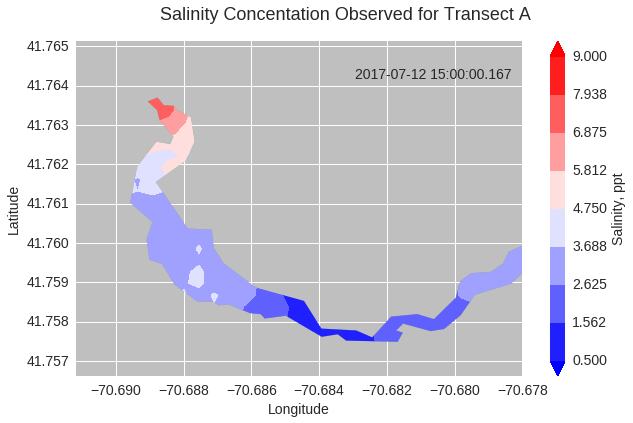

In [39]:
# Create clean datasets for the interpolation -- no null values, and no values with the same x-coordinate (or
# a singular matrix error will be thrown)
tad = ta[ta['airmar']['lon_mod'].notnull() & ta['airmar']['lat_mod'].notnull() & ta['ctd']['Salinity'].notnull()]
tad = tad[~tad['airmar']['lon_mod'].duplicated()]
tbd = tb[tb['airmar']['lon_mod'].notnull() & tb['airmar']['lat_mod'].notnull() & tb['ctd']['Salinity'].notnull()]
tbd = tbd[~tbd['airmar']['lon_mod'].duplicated()]
tcd = tc[tc['airmar']['lon_mod'].notnull() & tc['airmar']['lat_mod'].notnull() & tc['ctd']['Salinity'].notnull()]
tcd = tcd[~tcd['airmar']['lon_mod'].duplicated()]
tdd = td[td['airmar']['lon_mod'].notnull() & td['airmar']['lat_mod'].notnull() & td['ctd']['Salinity'].notnull()]
tdd = tdd[~tdd['airmar']['lon_mod'].duplicated()]
ted = te[te['airmar']['lon_mod'].notnull() & te['airmar']['lat_mod'].notnull() & te['ctd']['Salinity'].notnull()]
ted = ted[~ted['airmar']['lon_mod'].duplicated()]

# Perform the interpolation
a = Interp2_Animator([tad, tbd, tcd, tdd, ted],['Transect A', 'Transect B', 'Transect C', 'Transect D', 'Transect E'],
                  'ctd','Salinity','Salinity, ppt',
                  'Salinity Concentation Observed for ', 0.5, 9.0)
anim = a.get_animation()
anim.save('salinity_my_interpolation.gif', writer='imagemagick', fps=1)
HTML(anim.to_html5_video())

## Conclusions

By interpolating/extrapolating the information, a better sense of the "story" going on at the effluent site becomes more clear. By observing the animations, we can certainly see that the outflow (tide going out) in the estuary does carry both the effluent and the fresh estuarine water out with it. The wastewater effluent is a clear source of cold water, and methane. 

Future work with this dataset will include using the scalar field (related to time) to perform planning for information-gathering missions. 